<a href="https://colab.research.google.com/github/Wolfking2015/FacebookNetwork/blob/master/Module3_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question: What’s the Optimal Graph Model for the Facebook Network?


## Dataset:
[SNAP Facebook Dataset](https://snap.stanford.edu/data/ego-Facebook.html)

## **Methodology**:


1.   Assessing the presence of a power-law distribution within the network
2.   Based on the findings about the power-law distribution, explore how well the Facebook network aligns with the four primary network models, which include Erdos-Renyi, configuration, preferential attachment and small-world.
3. Through the comparison between the Facebook network and the graph model, determine the graph model that best matches the characteristics of the Facebook network.








In [7]:
import pandas as pd    # for reading and manipulating tabular data
import networkx as nx  # for constructing and studying networks
import numpy as np     # for arrays
#import community           # for community structure later
import collections          # for manipulation tuples and zipping objects
import statistics as stats  # for generating summary statistics
import time                 # for measuring computating time
from matplotlib import pyplot as plt  # for outputting nice plots
import seaborn as sns                 # for creating even nicer plots

In [8]:
!pip install python_louvain

In [9]:
get_ipython().magic(u'matplotlib inline')

In [10]:
from community import community_louvain # for nxv2

# Load the Facebook data and construct the graph

In [11]:
facebook_data_file = 'facebook_combined.txt'
# Create graph from edge list stored in data file
G = nx.read_edgelist(facebook_data_file,
                     create_using = nx.Graph(), # Use Graph() instead of DiGraph() for directed vs. undirected,
                     nodetype = int) # Do not forget to specify node information type

In [12]:
degree_sequence = sorted((G.degree[d] for d in range(len(G.degree))), reverse=True)  # for nx v2

In [13]:
nodes = G.nodes

In [14]:
degree_sequence = sorted((G.degree[d] for d in nodes),reverse=True)

In [15]:
degree_sequence = sorted((G.degree[d] for d in range(len(G.degree))), reverse=True)  # for nx v2
degree_count = collections.Counter(degree_sequence)
deg,cnt = zip(*degree_count.items())

## **Discrete probability power law distribution**

$p(k) = \frac{\alpha-1}{k_{min}}.(\frac{k}{k_{min}})^{-\alpha}$

- $\alpha$ is the power in the **power law**
- $k_{min}$ is the minimum degree for which the **discrete probability law** applies


For degree k greater than $k_{min}$:
$log(p(k)) = log(\frac{\alpha-1}{k_{min}}) - \alpha.log(\frac{k}{k_{min}})$

The above expression is linear in $log(\frac{k}{k_{min}})$.

In [16]:
# Log transform of the data
log_deg = np.log(deg)
log_cnt = np.log(cnt)

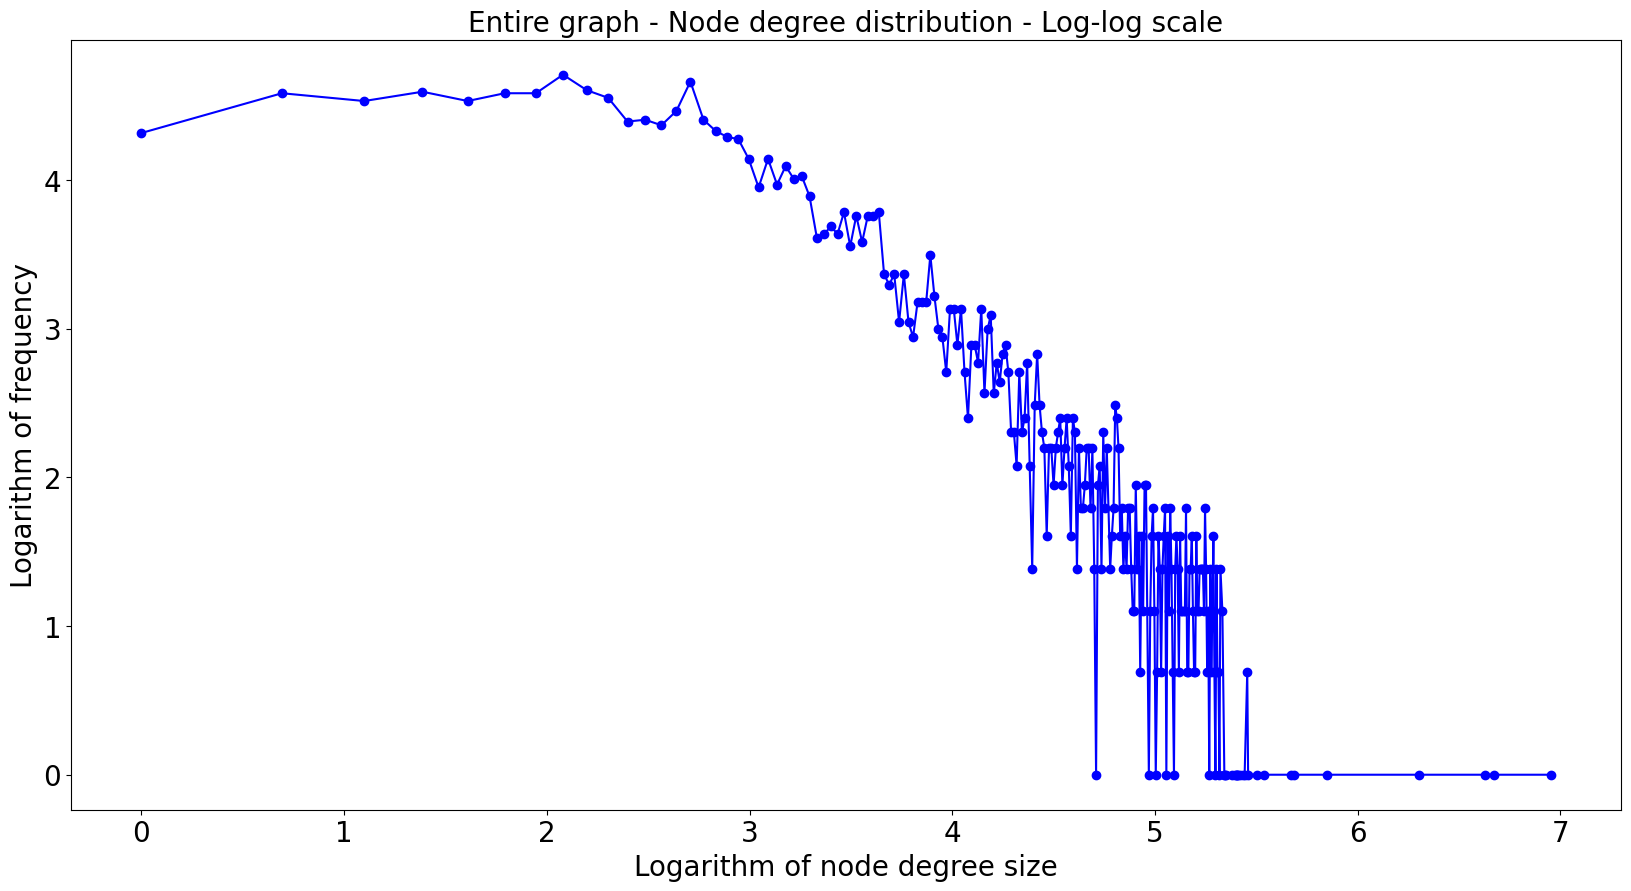

In [17]:

plt.figure(figsize=(20,10))


plt.plot(log_deg, log_cnt, color='b',marker= 'o')
plt.xlabel('Logarithm of node degree size', fontsize=20)
plt.ylabel('Logarithm of frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node degree distribution - Log-log scale", fontsize=20)
plt.show()

In [18]:
cnt_list =list(cnt)

# Scaling factor
division_factor = sum(cnt_list[:-1]) # remove degree = 1
cnt_proba_list = [cnt_list[i]/division_factor for i in range(len(cnt_list)-1)] # remove degree = 1

## Fitting with a linear model

In [19]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
deg_list = list(deg)[:-1]
kmin = 2


In [20]:
log_deg_list = [np.log(deg_list[i]/kmin) for i in range(len(deg_list))]
log_cnt_proba_list = [np.log(e) for e in cnt_proba_list]

In [21]:
X=pd.DataFrame({'log_deg':log_deg_list},columns=['log_deg'])

In [22]:
model = lm.fit(X,log_cnt_proba_list)

In [23]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

deg_list = list(deg)[:-1]
kmin = 2
log_deg_list = [np.log(deg_list[i]/kmin) for i in range(len(deg_list))]
log_cnt_proba_list = [np.log(e) for e in cnt_proba_list]
# Set up the matrix x (no need to create a column of 1's - the intercept is automatically considered when fitting the regression)
X = pd.DataFrame({'log_deg': log_deg_list}, columns=['log_deg'])

# Linear regression model
model = lm.fit(X, log_cnt_proba_list)

In [24]:
# Check the slope c
c = model.coef_[0]
print('Slope c: ', c)
# Deduce the value of alpha
alpha = -c
print('Exponent alpha: ', alpha)

Slope c:  -1.244820113441891
Exponent alpha:  1.244820113441891


In [25]:
# Check the intercept b
b = model.intercept_
print('Intercept b: ', b)
# Check whether it deviates from its theoretical value: log(alpha-1/kmin)
theoretical_b = np.log((alpha-1)/kmin)
print('Theoretical b, using the estimated value for alpha: ', theoretical_b)
print('% absolute error: ', np.round((-b+theoretical_b)/theoretical_b*100,1))

Intercept b:  -1.5324561967970896
Theoretical b, using the estimated value for alpha:  -2.1003787495262625
% absolute error:  27.0


### Goodness of fit

In [26]:
predictions = lm.predict(X)

In [27]:
errors = log_cnt_proba_list - predictions

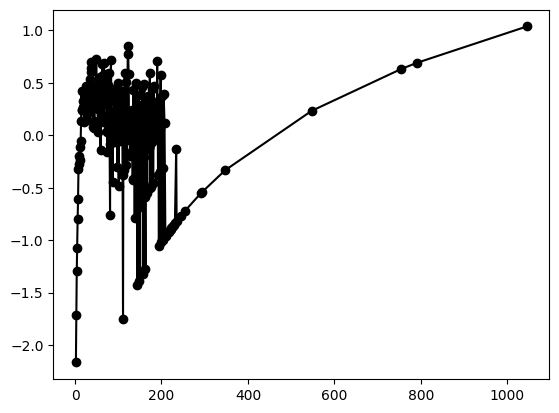

In [28]:
plt.plot(deg_list,errors,'-ok')

<ipython-input-29-6cddcf7ffdfa>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(degree_sequence, hist=False, rug=True)


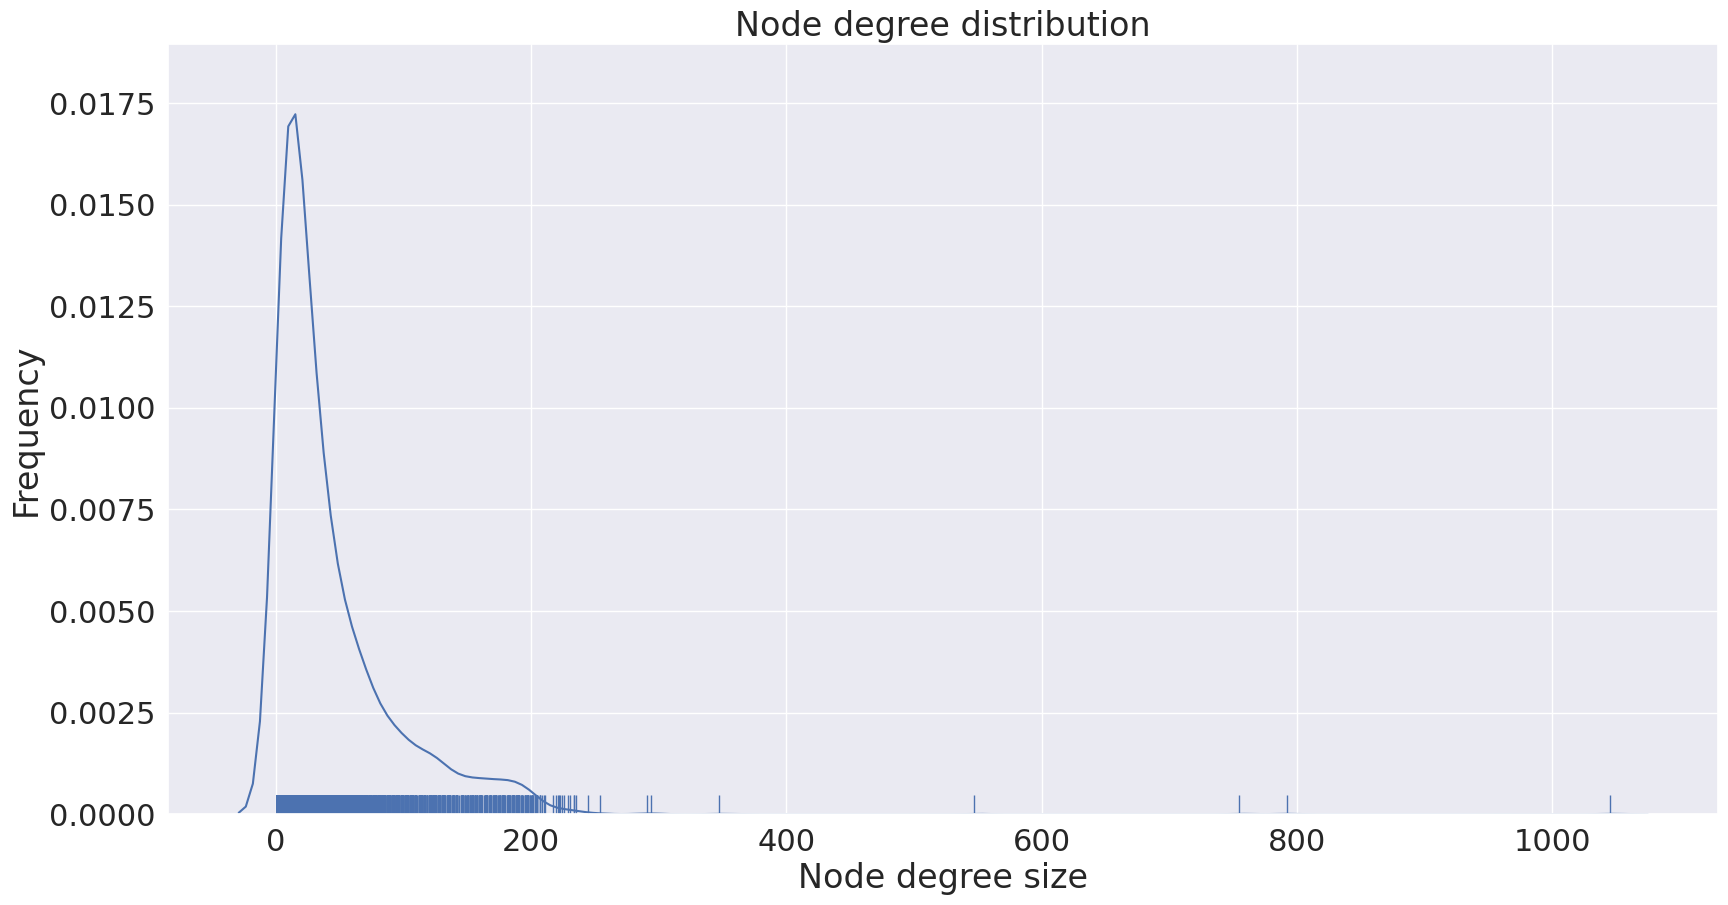

In [29]:
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax = sns.distplot(degree_sequence, hist=False, rug=True)
ax.set(xlabel="Node degree size",ylabel= "Frequency",title='Node degree distribution');
plt.show()

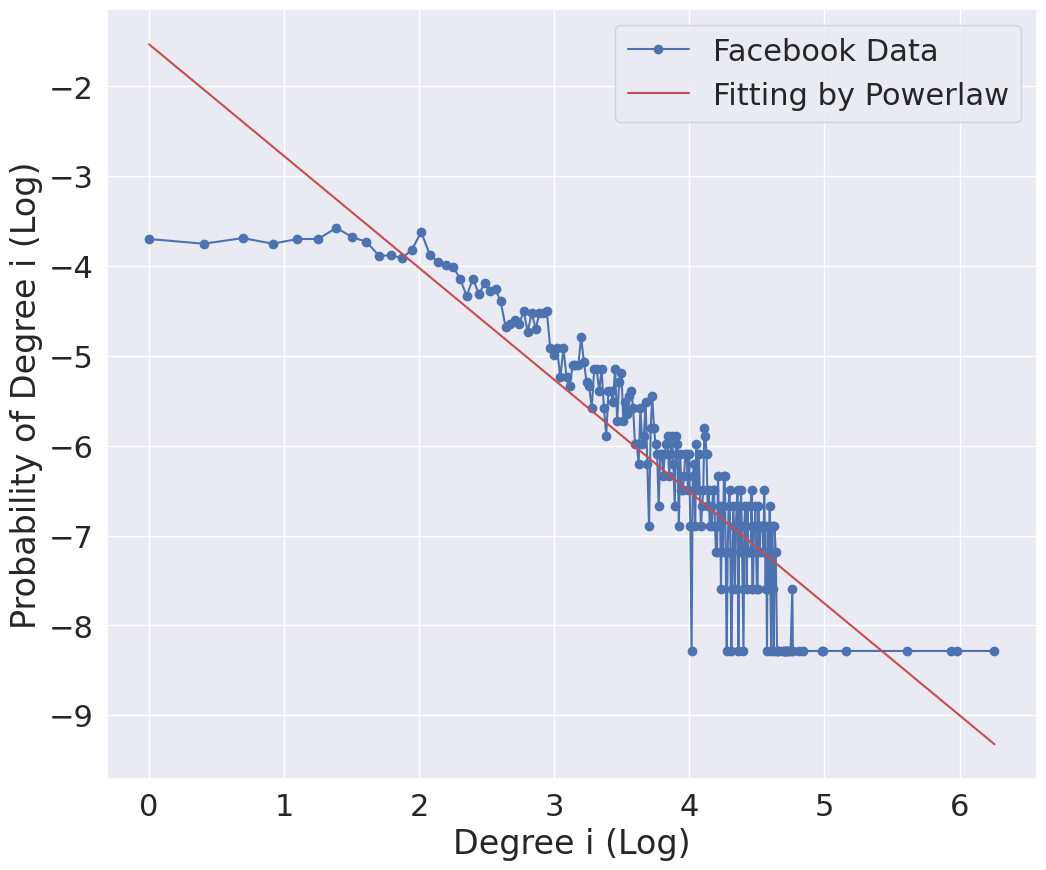

In [30]:
plt.figure(figsize=(12,10))
plt.plot(log_deg_list,log_cnt_proba_list,'-ob')
plt.plot(X,predictions,'-r')
plt.xlabel('Degree i (Log)')
plt.ylabel('Probability of Degree i (Log)')
plt.legend(['Facebook Data','Fitting by Powerlaw'])

### It seems that the Facebook network is not perfectly aligned with the Power-law degree distribution

## **2. Erdos-Renyi model**


In [31]:
def visualization_graph(g,pos,title):
  fig = plt.figure(figsize = (20, 10))
  ax = fig.add_subplot(111)
  ax.axis('off')

  node_size_default = 40

  n = nx.draw_networkx(g,
                     pos,
                     ax = ax,
                     node_size = node_size_default,
                     with_labels = False)
  plt.title(title)


In [52]:
# Generate an erdos-Renyi random graph with the same number of nodes and edge probability
n = len(G.nodes)
m = len(G.edges)
p = m/(n*(n-1)/2)
er_graph = nx.erdos_renyi_graph(n,p)

In [53]:
#Visualization
spring_pos_er = nx.spring_layout(er_graph) # might take a little while


Text(0.5, 1.0, 'Erdos-Renyi Model')

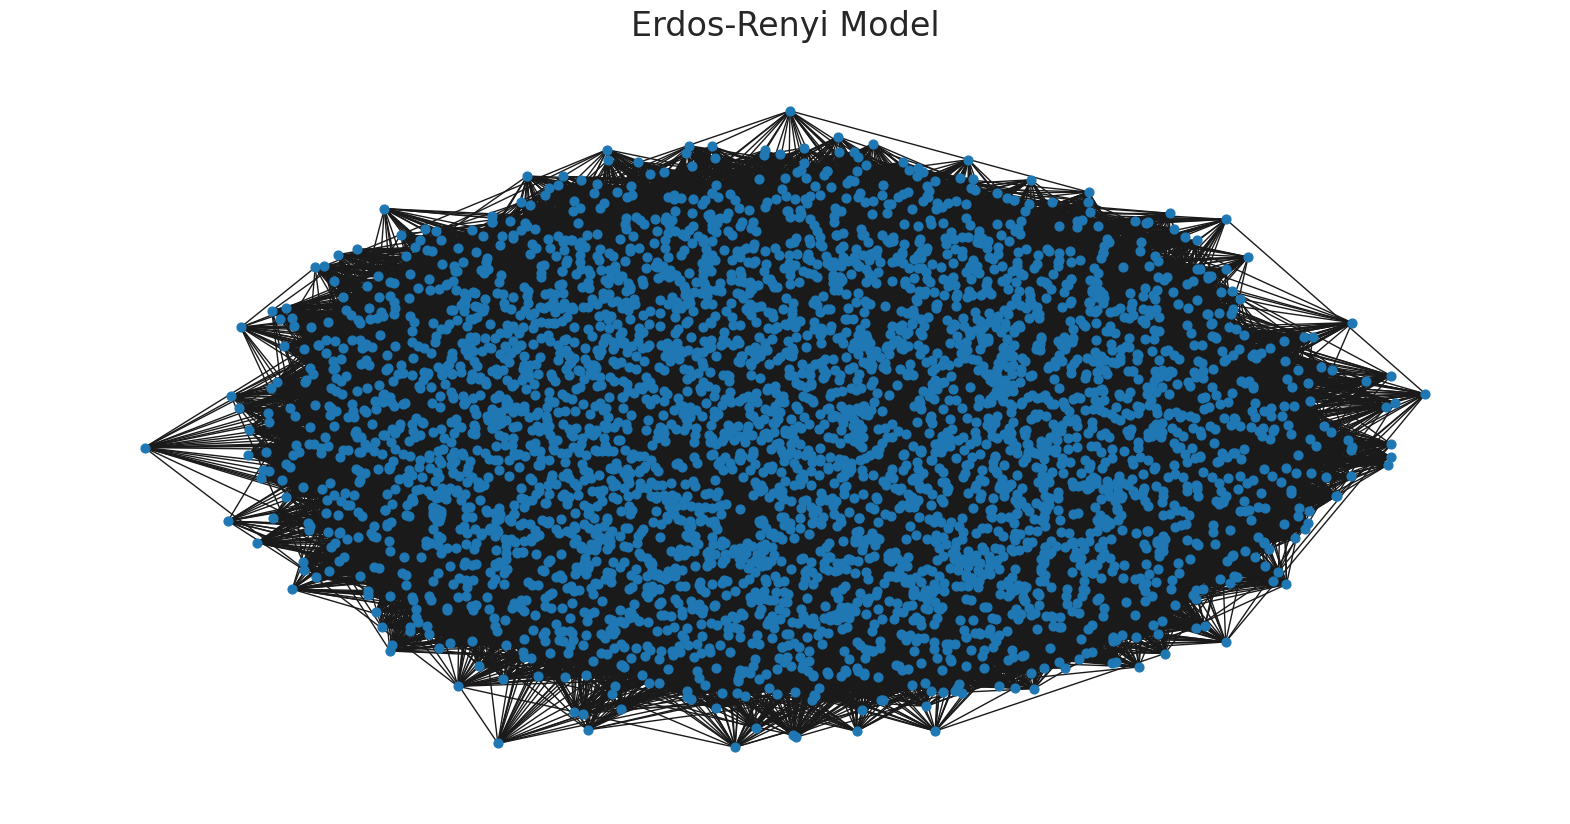

In [54]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

node_size_default = 40

n = nx.draw_networkx(er_graph,
                     spring_pos_er,
                     ax = ax,
                     node_size = node_size_default,
                     with_labels = False)
plt.title("Erdos-Renyi Model")


## **The Configuration Model**

In [35]:
# Generate a configuration model with the same degree sequence
degree_sequence = [degree for node, degree in G.degree()]
config_model = nx.configuration_model(degree_sequence, seed=42)



In [36]:
#Visualization
spring_pos_config = nx.spring_layout(config_model) # might take a little while

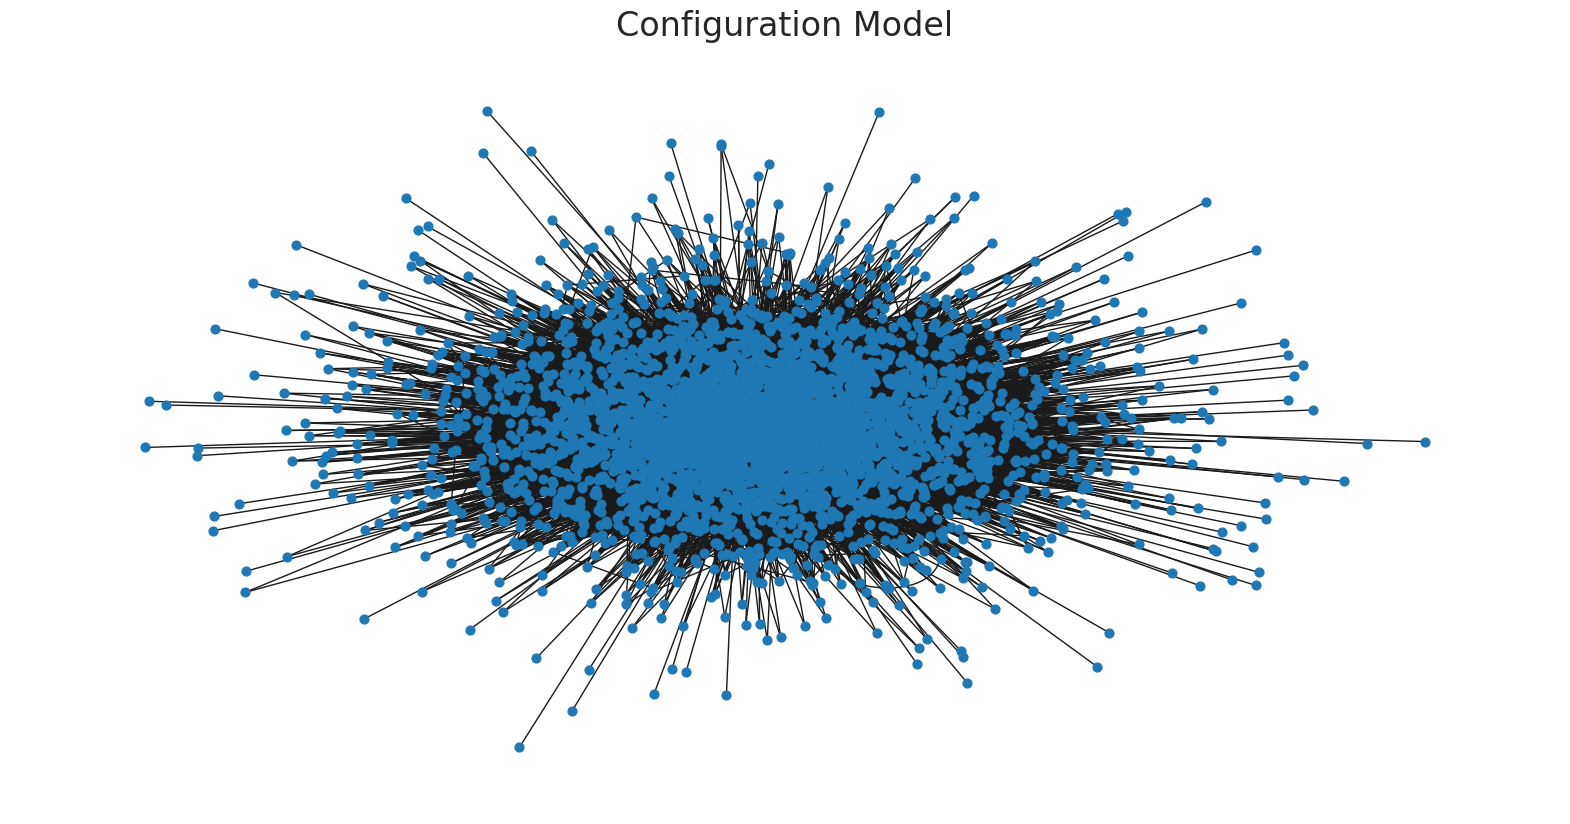

In [37]:
visualization_graph(config_model,spring_pos_config,'Configuration Model')

## **Small World Graph**

In [70]:
# Generate a small-world model
n = len(G)
k = 8  # Adjust k based on network characteristics
p = m/(n*(n-1)/2)  # Adjust p based on network characteristics
small_world_model = nx.watts_strogatz_graph(n, k, p)




In [71]:
n

4039

In [39]:
#Visualization
spring_pos_sw = nx.spring_layout(small_world_model) # might take a little while


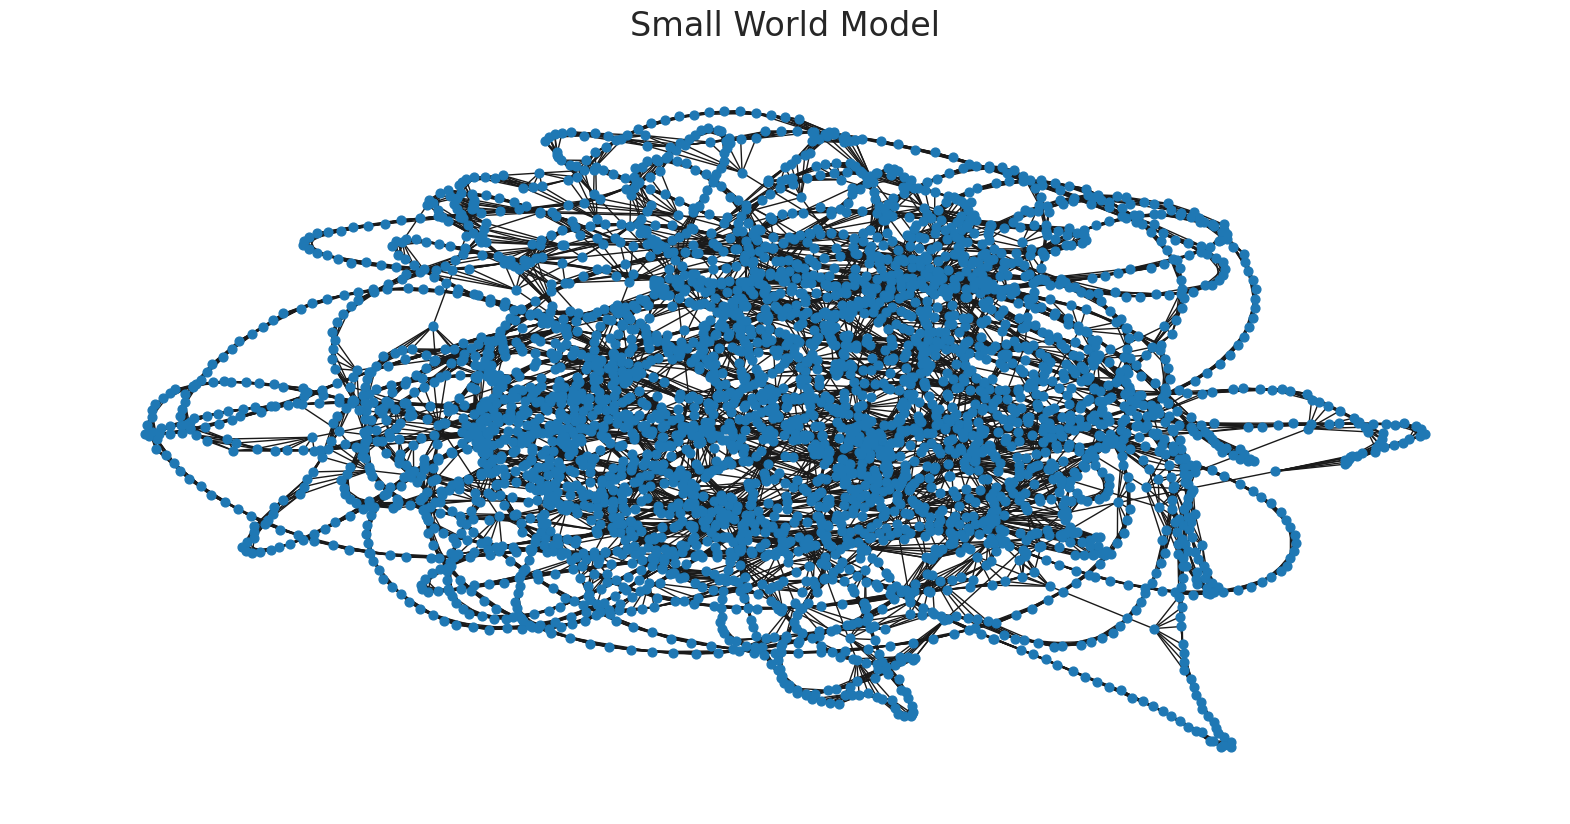

In [40]:
visualization_graph(small_world_model,spring_pos_sw,'Small World Model')

## **Preferential attachment model**

###The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. Several natural and human-made systems, including the Internet, the World Wide Web, citation networks, and some social networks are thought to be approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network. The BA model tries to explain the existence of such nodes in real networks. The algorithm is named for its inventors Albert-László Barabási and Réka Albert.

In [65]:
import random
def preferential_attachment_model(num_nodes, num_edges):
    G = nx.Graph()
    G.add_edge(0, 1)  # Initialize with two connected nodes

    for i in range(2, num_nodes):
      neighbors = sorted(G.nodes(),key = lambda x: G.degree(x))
      targets = neighbors[random.randint(0,len(neighbors)-1)]
      G.add_edge(i,targets)


    return G

In [73]:
n
m

88234

In [74]:
pa_model = preferential_attachment_model(n,m)

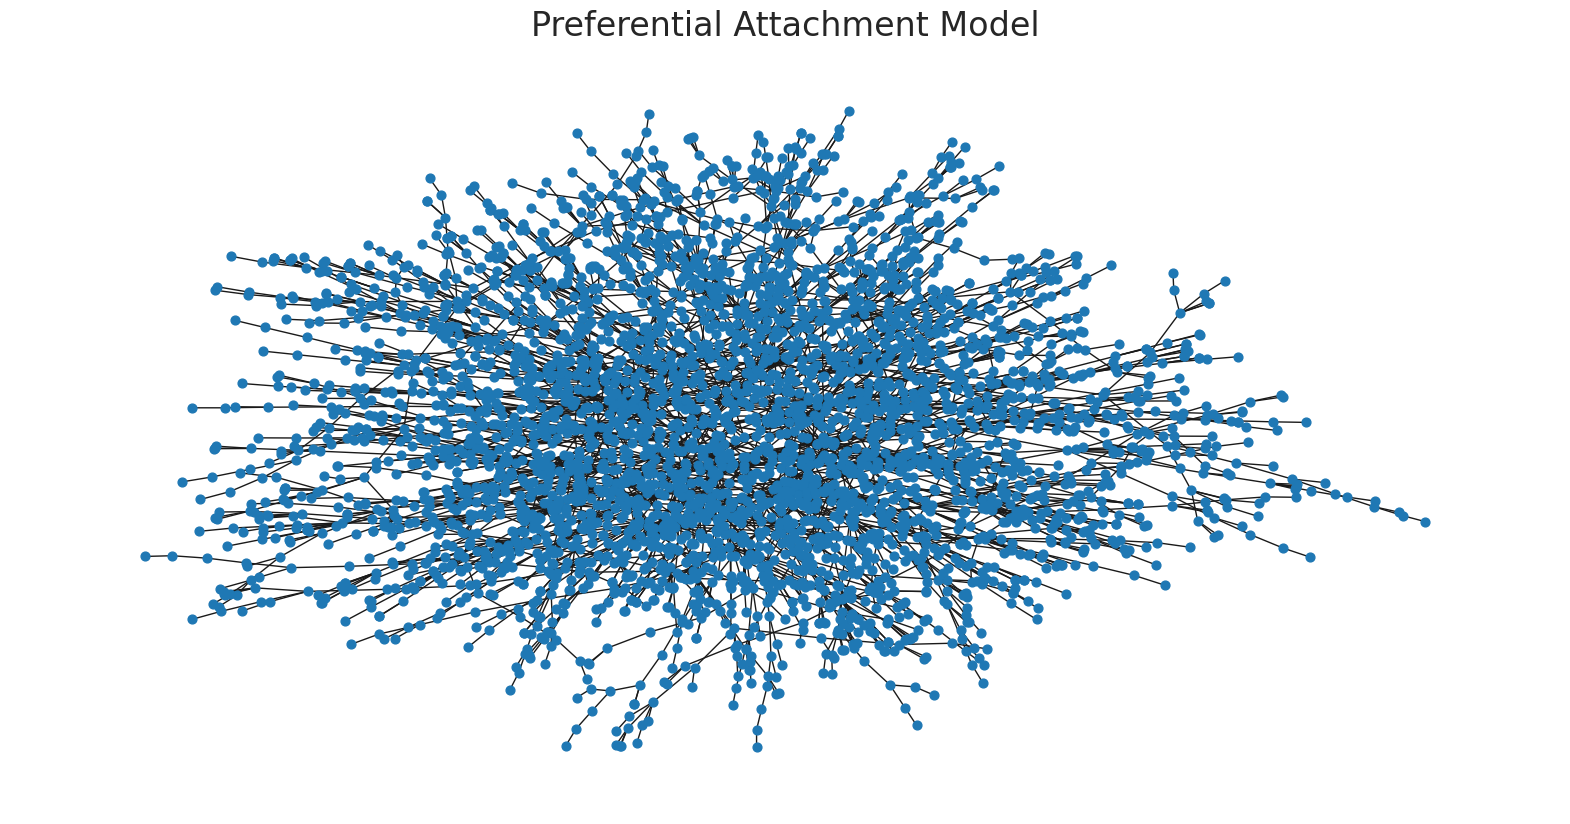

In [75]:
#Visualization
spring_pos_pa = nx.spring_layout(pa_model) # might take a little while
visualization_graph(pa_model,spring_pos_pa,'Preferential Attachment Model')

# **Facebook Network**

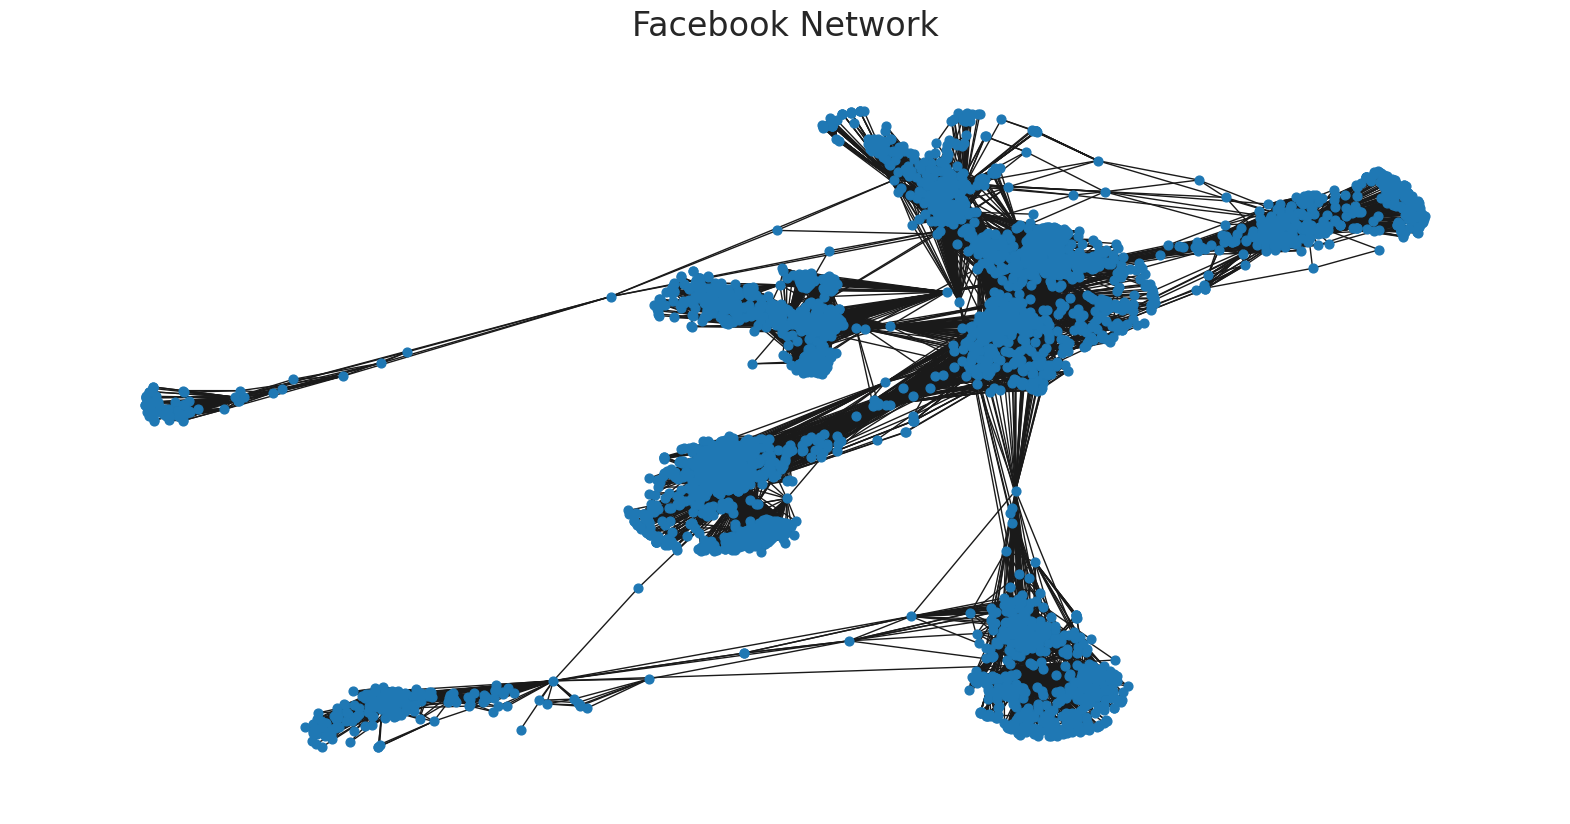

In [41]:
spring_pos_g = nx.spring_layout(G) # might take a little while
visualization_graph(G,spring_pos_g,'Facebook Network')

# **Comparing the graph models with the real-world Facebook network**

## The choice of features to compare:

***Degree Distribution***: Compare the degree distribution of the Facebook network with the expected degree distribution of an graph. You can use degree histograms or probability density functions (PDFs) to visualize and compare the distributions.

***Average Clustering Coefficient***: Calculate and compare the average clustering coefficient of both networks. The Facebook network might have a higher average clustering coefficient than an random graph due to the presence of clusters and communities.

***Network Diameter***: Compare the diameter (longest shortest path) of the Facebook network with that of the Graph model. Real-world networks often have shorter diameters than random networks.

***Centrality Measures***: Compare centrality measures like degree centrality, betweenness centrality, closeness centrality, and eigenvector centrality. Are there nodes with exceptionally high centrality in the Facebook network?



## **1. Degree distribution**

In [98]:
def DegreeDistribution(g,title):
  degree_sequence = sorted((g.degree[d] for d in range(len(g.degree))), reverse=True)  # for nx v2
  degree_count = collections.Counter(degree_sequence)
  #deg,cnt = zip(*degree_count.items())
  #plt.figure(figsize=(20,10))
  sns.set(font_scale=2)
  ax = sns.distplot(degree_sequence, hist=True, rug=False)
  ax.set(xlabel="Node degree size",ylabel= "Frequency",title=title);
  plt.show()






<ipython-input-98-116925e5fd85>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(degree_sequence, hist=True, rug=False)


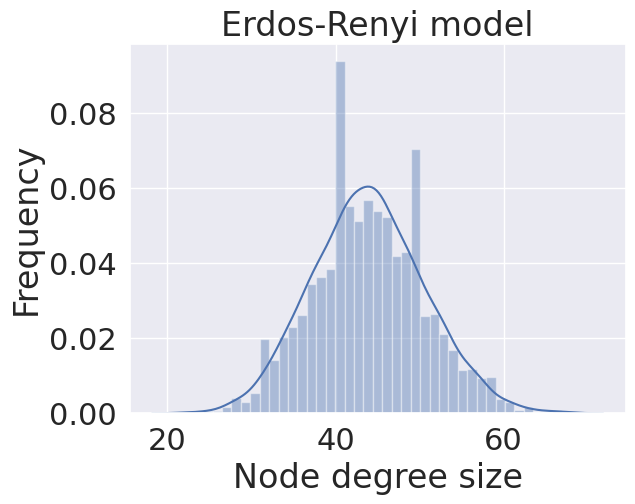

In [99]:

DegreeDistribution(er_graph,'Erdos-Renyi model')



<ipython-input-98-116925e5fd85>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(degree_sequence, hist=True, rug=False)


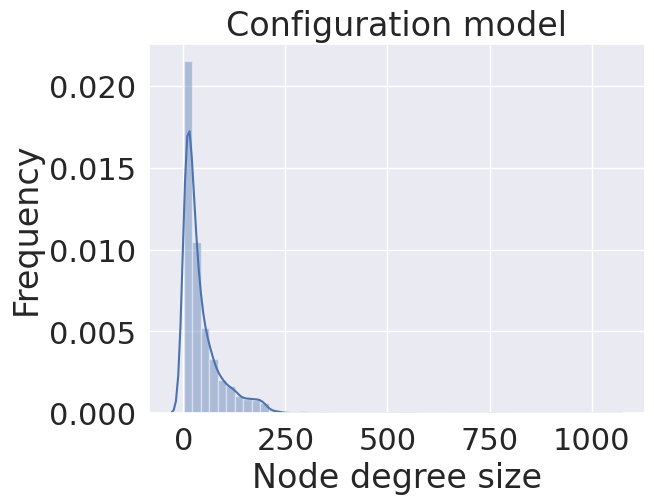

In [100]:
DegreeDistribution(config_model,'Configuration model')

<ipython-input-98-116925e5fd85>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(degree_sequence, hist=True, rug=False)


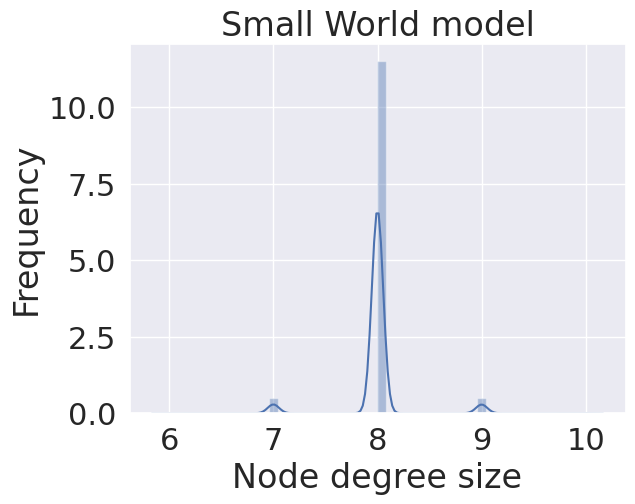

In [101]:
DegreeDistribution(small_world_model,'Small World model')

<ipython-input-98-116925e5fd85>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(degree_sequence, hist=True, rug=False)


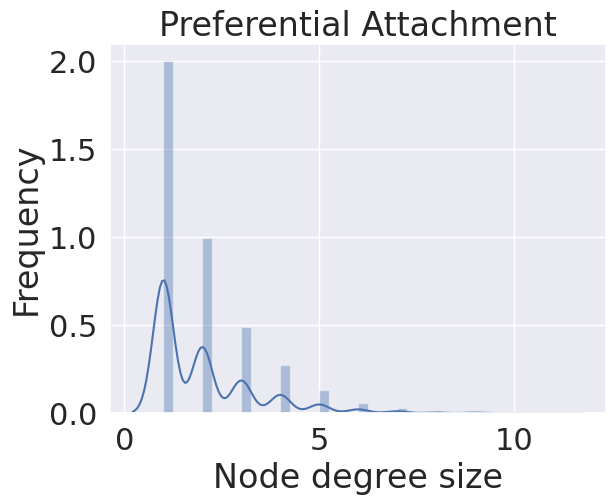

In [102]:
DegreeDistribution(pa_model,'Preferential Attachment')

<ipython-input-98-116925e5fd85>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(degree_sequence, hist=True, rug=False)


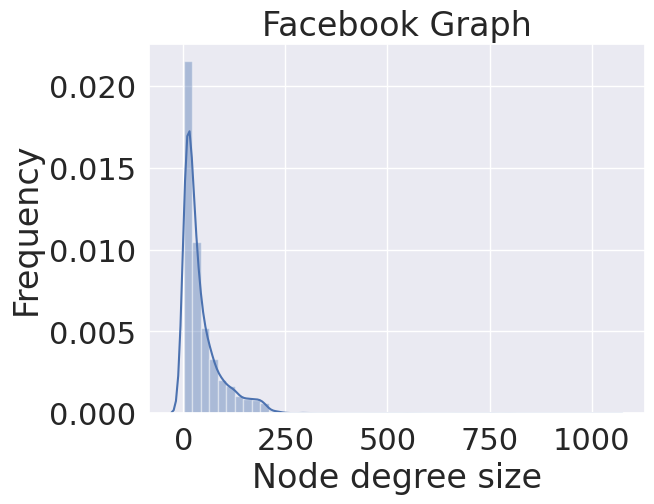

In [103]:
DegreeDistribution(G,'Facebook Graph')

# **2. Average Clustering Coefficient**

In [56]:
avg_clustering_facebook = nx.average_clustering(G)
avg_clustering_er = nx.average_clustering(er_graph)
avg_clustering_config = nx.average_clustering(nx.Graph(config_model))
avg_clustering_smallworld = nx.average_clustering(small_world_model)



In [77]:
avg_clustering_pa = nx.average_clustering(pa_model)

In [80]:
avg_clustering_pa

0.0

Text(0.5, 1.0, 'Comparison of Average Clustering Coefficient')

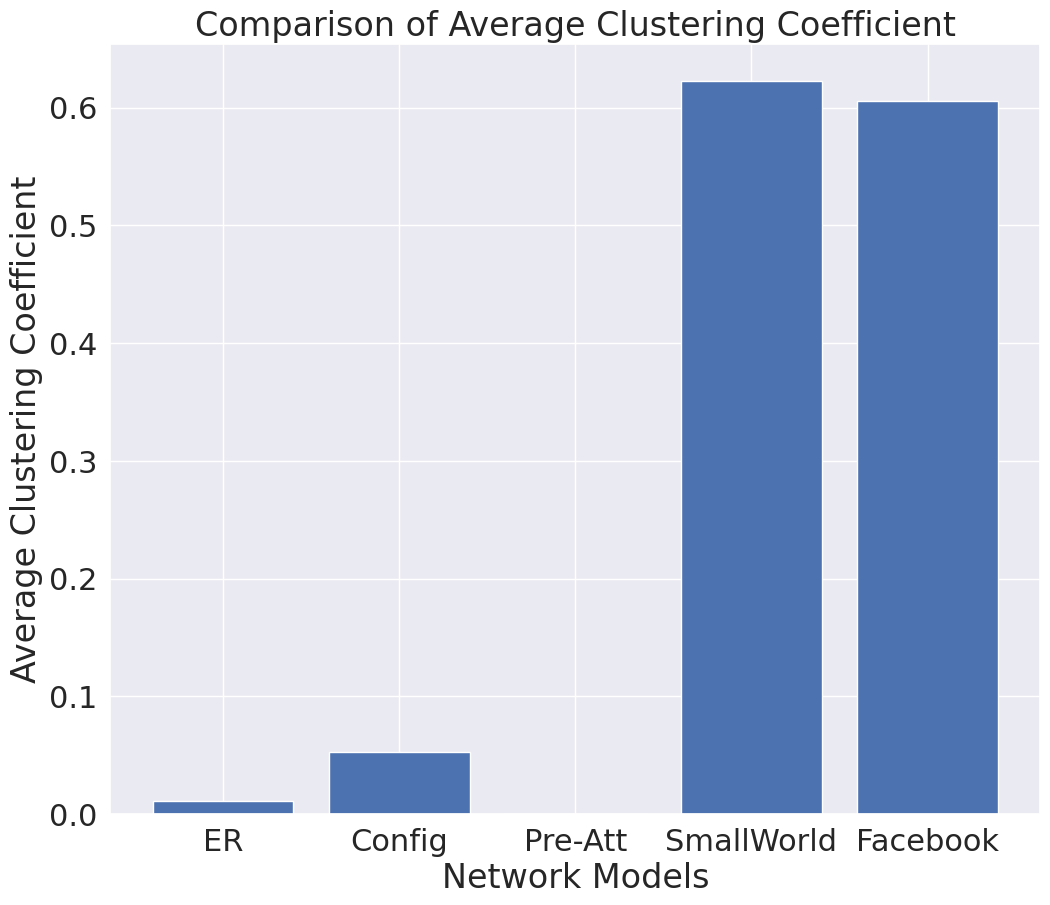

In [79]:
plt.figure(figsize=(12,10))
plt.bar([1,2,3,4,5],[avg_clustering_er,avg_clustering_config,avg_clustering_pa,avg_clustering_smallworld,avg_clustering_facebook])
labels = ['ER', 'Config',  'Pre-Att','SmallWorld','Facebook']
plt.xticks([1, 2, 3, 4,5], labels)
plt.xlabel('Network Models')
plt.ylabel('Average Clustering Coefficient')
plt.title('Comparison of Average Clustering Coefficient')

## **3. Average diameter**

In [60]:
er_diameter = nx.diameter(er_graph)
config_diameter = nx.diameter(config_model)
sw_diameter = nx.diameter(small_world_model)
fb_diameter = nx.diameter(G)



In [82]:
pa_diameter = nx.diameter(pa_model)

Text(0.5, 1.0, 'Comparison of Diameter')

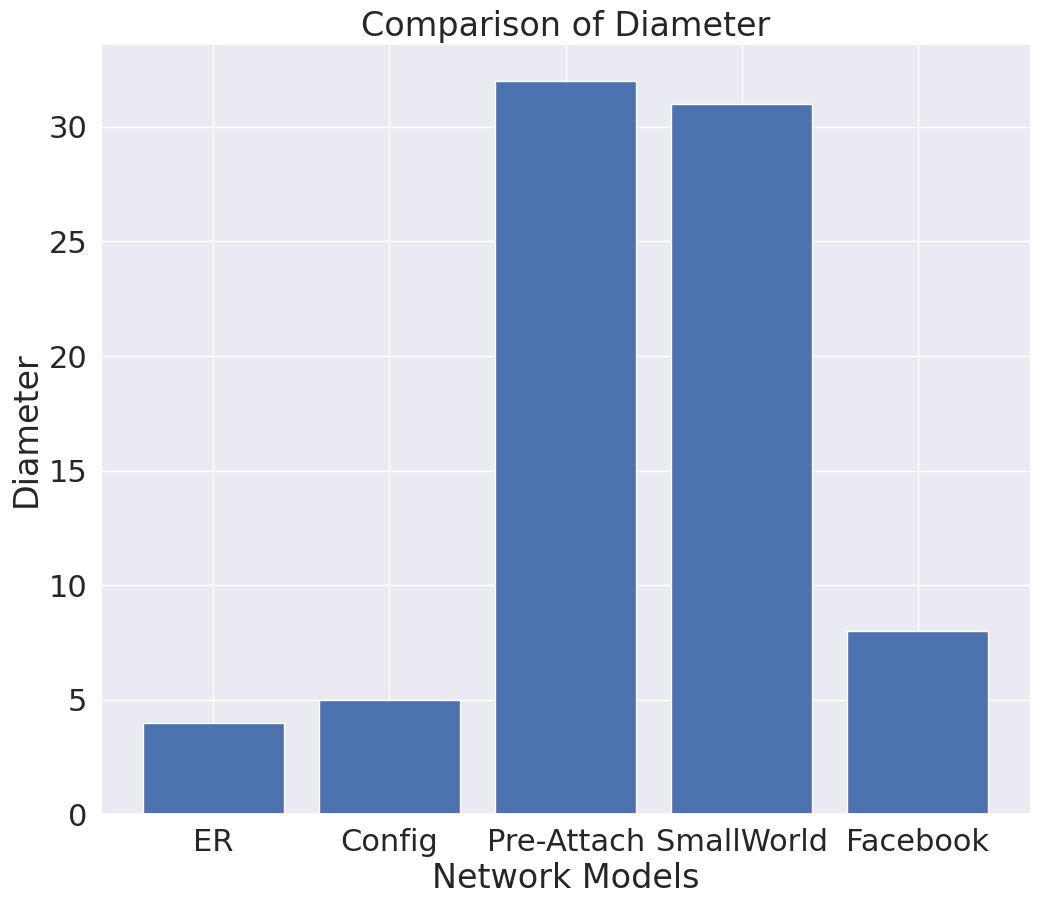

In [83]:
plt.figure(figsize=(12,10))
plt.bar([1,2,3,4,5],[er_diameter,config_diameter,pa_diameter,sw_diameter,fb_diameter])
labels = ['ER', 'Config','Pre-Attach', 'SmallWorld', 'Facebook']
plt.xticks([1, 2, 3, 4,5], labels)
plt.xlabel('Network Models')
plt.ylabel('Diameter')
plt.title('Comparison of Diameter')

## **3. Centrality Measures**

### 1. Closeness centrality

In [113]:
def distributionC(c,t,title):
  c_sequence = sorted((c[d] for d in range(len(c))), reverse=True)
  sns.set(font_scale=2)
  ax = sns.distplot(c_sequence, hist=True, rug=False)
  ax.set(xlabel=t,ylabel= "Frequency",title=title);
  plt.xlim(0, 0.5)

  plt.show()



<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


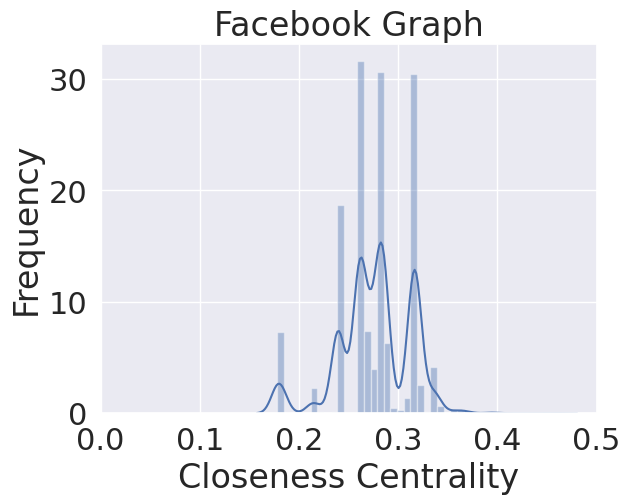

In [114]:
close_fb = nx.closeness_centrality(G)

distributionC(close_fb,'Closeness Centrality','Facebook Graph')


<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


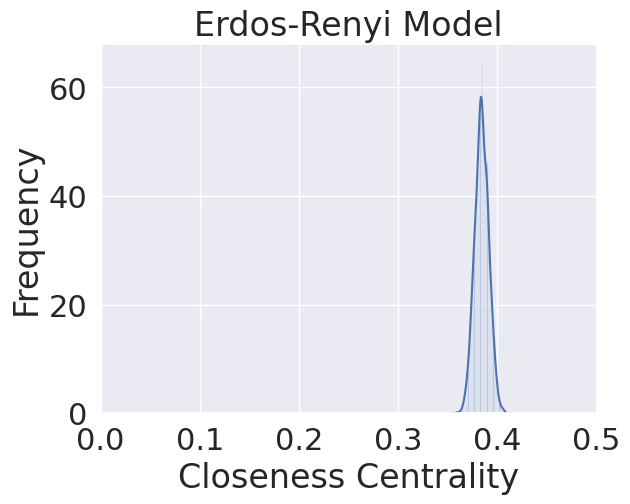

In [115]:
close_er = nx.closeness_centrality(er_graph)
distributionC(close_er,'Closeness Centrality','Erdos-Renyi Model')

<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


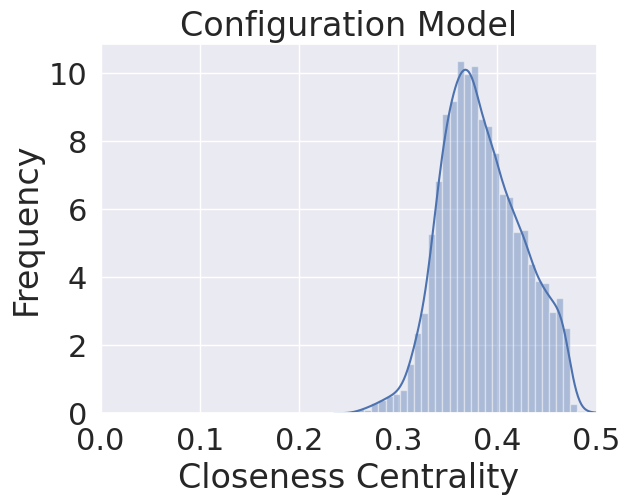

In [116]:
close_config = nx.closeness_centrality(config_model)
distributionC(close_config,'Closeness Centrality','Configuration Model')

<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


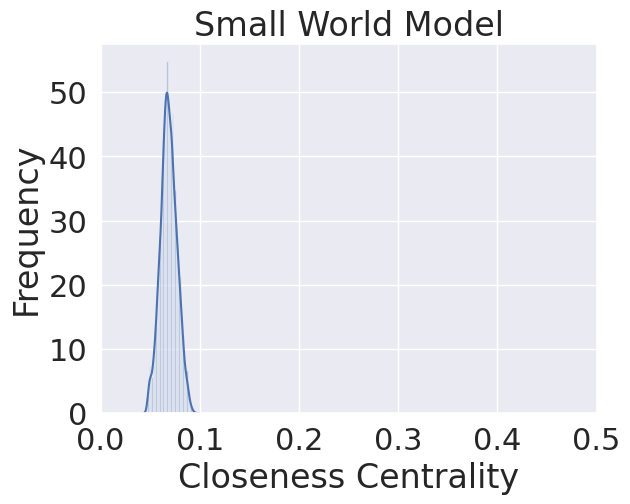

In [117]:
smallworld_config = nx.closeness_centrality(small_world_model)
distributionC(smallworld_config,'Closeness Centrality','Small World Model')

## 2. Eigenvalue Centrality

In [120]:
eig_fb = nx.eigenvector_centrality(G)
eig_er = nx.eigenvector_centrality(er_graph)
eig_config = nx.eigenvector_centrality(nx.Graph(config_model))
eig_sm = nx.eigenvector_centrality(small_world_model,max_iter=1000)

<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


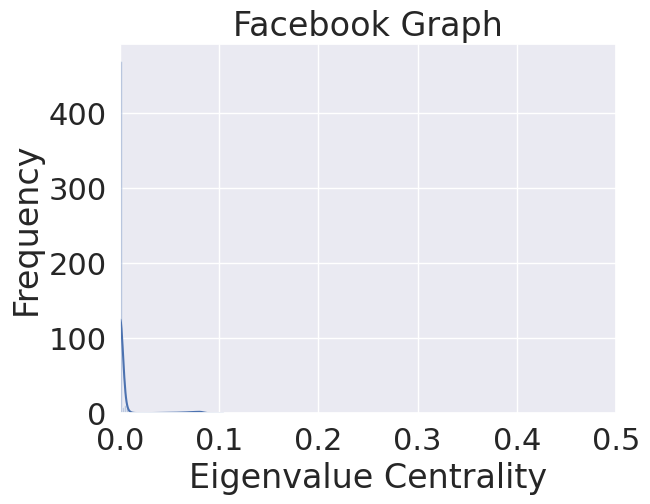

In [126]:
distributionC(eig_fb,'Eigenvalue Centrality','Facebook Graph')

<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


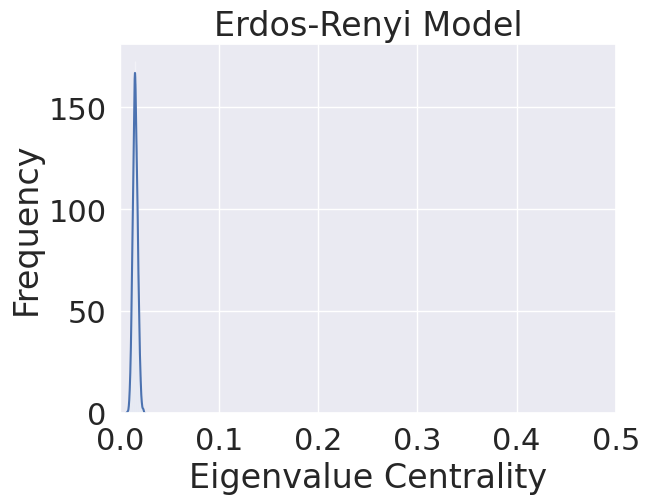

In [123]:
distributionC(eig_er,'Eigenvalue Centrality','Erdos-Renyi Model')

<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


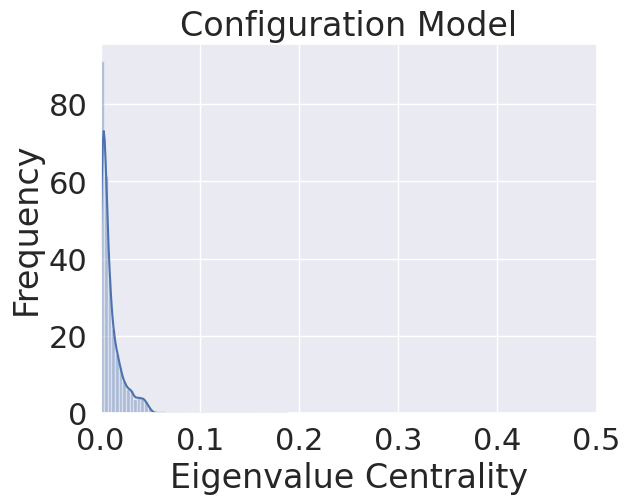

In [121]:
distributionC(eig_config,'Eigenvalue Centrality','Configuration Model')

<ipython-input-113-f5eb669b429b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(c_sequence, hist=True, rug=False)


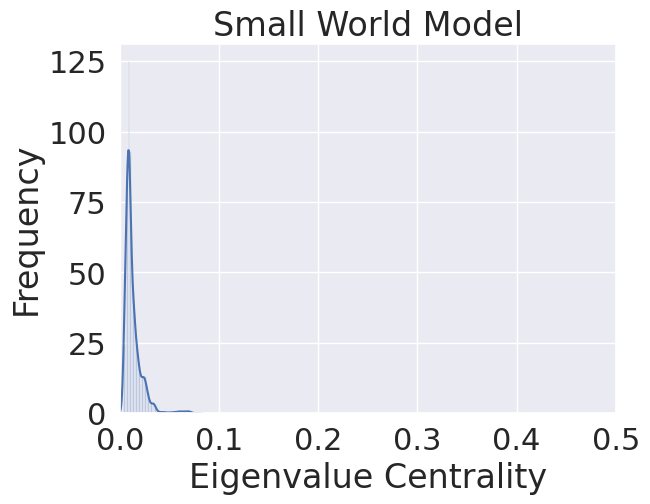

In [127]:
distributionC(eig_sm,'Eigenvalue Centrality','Small World Model')

## **Summary**

## 1. The structure of the Facebook graph does not conform perfectly to a power-law degree distribution. The deviation can be attributed to the typical user behavior on Facebook. Most users maintain a limited number of friends. Although there may be a few notable users, such as celebrities, who accumulate a larger number of followers and friends, their representation in the network remains relatively low. A more comprehensive analysis, incorporating additional factors like age, role, gender, geographical locations, and occupations, is essential to gain deeper insights into the underlying characteristics of the Facebook graph.


## 2. Three distinct models, i.e. Erdos-Renyi model, Configuration model, Small World model, are created to approximate the structure of the real world Facebook network. The preferential attachment model was intentionally excluded as it adheres to the power-law degree distribution feature, which doesn’t align with the characteristics of the Facebook network. Each model exhibits its own set of strengths and crucial attributes in terms of degree distribution, diameter, centrality distribution that mirror certain aspects of the Facebook graph. However, it’s important to note that none of them fully replicate the local clusters present within the intricate structure of the Facebook network.


## 3. As a result, the optimal graph model for Facebook graph depends on specific contexts and research objectives. If the research emphasizes understanding how the entire network emerges from randomness and how this randomness contributes to distinct network structures, the Ergo-Renyi model is supposed to be a suitable option according to this study. On the other hand, if the research focuses on replicating the Facebook network’s structure based on equivalent degrees and edge numbers, the Configuration model becomes the preferred choice. Furthermore, the Small World model stands out for its capacity to exhibit small-world characteristics.
